# Quickstart

The starting point for geospatial analysis is geospatial data. ``geoplot`` is designed to work with ``geopandas`` ``GeoDataFrame`` data. 

## Geospatial data

In [1]:
import geopandas as gpd
import geoplot as gplt

# Only necessary if working in a Jupyter environment.
%matplotlib inline

If you've never seen a ``GeoDataFrame``, it is quite simple: it's just a ``pandas`` ``DataFrame`` with a column reserved for ``geometry``. This column contains a list of ``shapely.geometry`` objects describing the physical nature of the record in question: a point in space, or a state shaped polygon, and so on.

In [2]:
# Unclutter the display.
import pandas as pd; pd.set_option('max_columns', 6)

# Load and display some example data.
# All of the examples in this notebook use the `quilt` package to do this.
from quilt.data.ResidentMario import geoplot_data
continental_cities = gpd.read_file(geoplot_data.usa_cities()).query('POP_2010 > 100000')
contiguous_usa = gpd.read_file(geoplot_data.contiguous_usa())
continental_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
3,177,105549.0,902.0,ND,POINT (-96.78980339999998 46.87718630000012)
30,373,210565.0,505.0,NY,POINT (-77.61555679999998 43.15478450000012)
34,378,145170.0,397.0,NY,POINT (-76.14742439999998 43.04812210000017)
39,386,261310.0,600.0,NY,POINT (-78.87836889999994 42.8864468000001)
61,426,106519.0,118.0,MA,POINT (-71.31617179999989 42.63342470000003)


## Plotting your data

We can easily plot all of these cities on a map using the ``geoplot`` ``pointplot`` functionality. However, points in space are hard to interpret. To add geospatial context, we'll overlay United States state shapes as well, using the ``polyplot`` function.

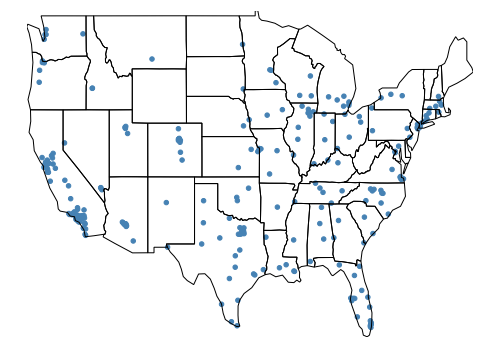

In [3]:
ax = gplt.pointplot(continental_cities)
gplt.polyplot(contiguous_usa, ax=ax)

There we go, our first ``geoplot`` plot! 

Unfortunately this map of the United States looks very strange. 

The Earth, being a sphere, is impossible to potray in two dimensionals. Hence, whenever we take data off the sphere and place it onto a webmap, we are using some kind of "projection", or method of flattening the sphere. In this case we plotted the dataset coordinates carte blanche&mdash;a really lousy projection!

We can "fix" the distortion by using an appropriate projection. The Albers equal area projection is one most common in the United States. To use it in ``geoplot``, here's what you do:

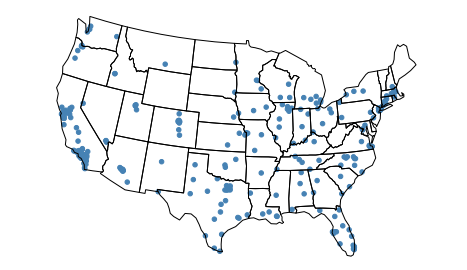

In [4]:
import geoplot.crs as gcrs

proj = gcrs.AlbersEqualArea()
# proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

ax = gplt.polyplot(contiguous_usa, projection=proj)
gplt.pointplot(continental_cities, ax=ax, projection=proj)

This looks much better than our first plot! In fact, this is the version of the United States that you'll probably most often see in maps; and it's just one of [dozens of projections](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html) provided in the ``geoplot.crs`` (shorthand ``gcrs``) namespace.

Of course, ``geoplot`` has many options for customization. A much fancier version of this plot follows.

Text(0.5,1,'Cities in the contiguous United States, 2010')

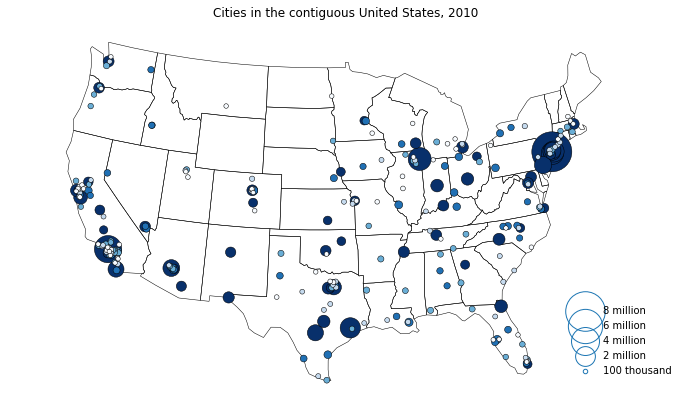

In [5]:
import matplotlib.pyplot as plt

proj = gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

ax = gplt.polyplot(contiguous_usa, 
                   projection=proj,
                   zorder=-1,  # Place the state shapes BELOW the cities.
                   linewidth=0.5,  # Make the state borders very thin.
                   figsize=(12, 12))  # Make the figure bigger.

gplt.pointplot(continental_cities, 
               scale='POP_2010',  # Set circle size based on population...
               limits=(1, 80),  # ...with the biggest 80 times the smallest.
               hue='POP_2010',  # Changing the color with population, too...
               cmap='Blues',  # ...more blue, more people...
               k=5,  # but let's limit ourselves to five "classes" of city sizes.
               linewidth=0.5,  # Circle borders are thin...
               edgecolor='black',  # ...and black.
               legend=True,  # Show a legend...
               legend_var='scale',  # ...based on circle size...
               legend_values=[8000000, 6000000, 4000000, 2000000, 100000],
               legend_labels=['8 million', '6 million', '4 million',
                              '2 million', '100 thousand'],  # ...with these five values...
               legend_kwargs={'frameon': False, 'loc': 'lower right'},  # ...on the lower right!
               ax=ax, projection=proj)

ax.set_ylim((-1597757, 1457718)); pass

plt.title("Cities in the contiguous United States, 2010")  # Add a title!

As you can see, we can generate some very pretty plots!

There are a few variables used here that are particularly worth pointing out.

First of all, note that this map is a double visual variable plot: the *size* and *color* of each circle equivalently present useful information about the marked city. The former is controlled by the ``scale``, and the latter, the ``hue``; both reference the ``POP_2010`` column in the dataset.

Second of all, note that we specify ``k=5``. This parameter controls how many "bins" of color are in the dataset. Because of this parameter, this plot categories all of the cities into one of five colors, with an approximately equivalent number of cities in each category. In your own work, you can choose to use more categories, or even none at all (by specifying ``k=None``)! Five just happened to work well for this particular dataset.

Finally, it's worth pointing out that the ``geoplot`` types have (broadly) the same parameters, so most of the parameters you see here will work in any of them.

## More plot options

For ease of use, before continuing, let's preload all of the example data we will use in this short walkthrough.

In [6]:
import matplotlib.pyplot as plt

collisions = gpd.read_file(geoplot_data.nyc_collision_factors())
boroughs = gpd.read_file(geoplot_data.nyc_boroughs())
census_tracts = gpd.read_file(geoplot_data.ny_census_partial())
percent_white = census_tracts['WHITE'] / census_tracts['POP2000']
obesity = geoplot_data.obesity_by_state()
contiguous_usa = gpd.read_file(geoplot_data.contiguous_usa())
contiguous_usa['Obesity Rate'] = contiguous_usa['State'].map(
    lambda state: obesity.query("State == @state").iloc[0]['Percent']
)
la_flights = gpd.read_file(geoplot_data.la_flights())
la_flights = la_flights.assign(
    start=la_flights.geometry.map(lambda mp: mp[0]),
    end=la_flights.geometry.map(lambda mp: mp[1]))

With that done, let's take a look at some other plot types.

If you have a lot of points, too many to useful plot one-at-a-time, you can aggregate them using a ``kdeplot``. This provides a nice understanding of density:

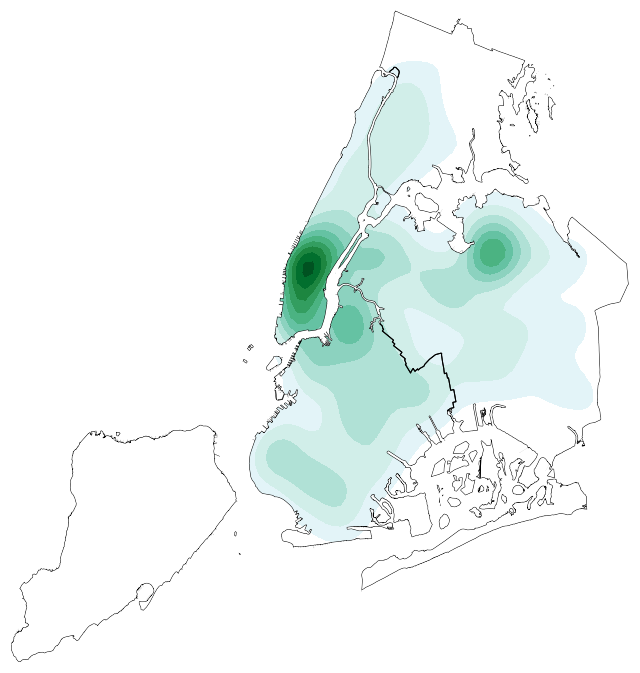

In [7]:
collisions = gpd.read_file(geoplot_data.nyc_collision_factors())
boroughs = gpd.read_file(geoplot_data.nyc_boroughs())

ax = gplt.kdeplot(collisions, 
                  projection=gcrs.AlbersEqualArea(), 
                  shade=True,  # Shade the areas or draw relief lines?
                  shade_lowest=False,  # Don't shade near-zeros.
                  clip=boroughs.geometry,  # Constrain the heatmap to this area.
                  figsize=(12,12))
gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), ax=ax)

A similar effect can be achieved using fewer points with the ``voronoi``:

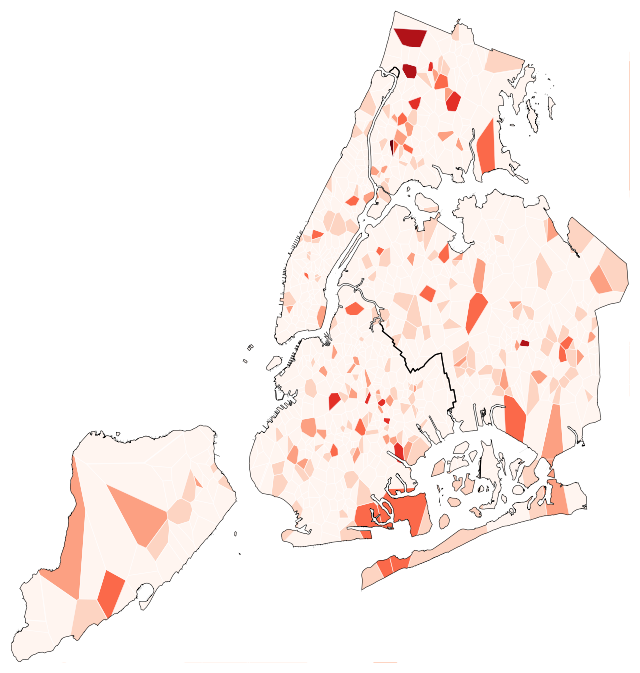

In [8]:
boroughs = gpd.read_file(geoplot_data.nyc_boroughs())
injurious_collisions = gpd.read_file(geoplot_data.nyc_injurious_collisions())

import geoplot as gplt

ax = gplt.voronoi(injurious_collisions.head(1000), 
                  hue='NUMBER OF PERSONS INJURED', cmap='Reds',
                  edgecolor='white', clip=boroughs.geometry,
                  linewidth=0.5, categorical=True, 
                  projection=gcrs.AlbersEqualArea(), 
                  figsize=(12,12))
gplt.polyplot(boroughs, linewidth=1, projection=gcrs.AlbersEqualArea(), ax=ax)

Not all geometric data has to be point data, of course. The second most common type of geometric data is shapes: things like states, counties, survey areas, and so on. The most immediate tool for visualing data that comes attached to shapes such as these is the ``choropleth``:

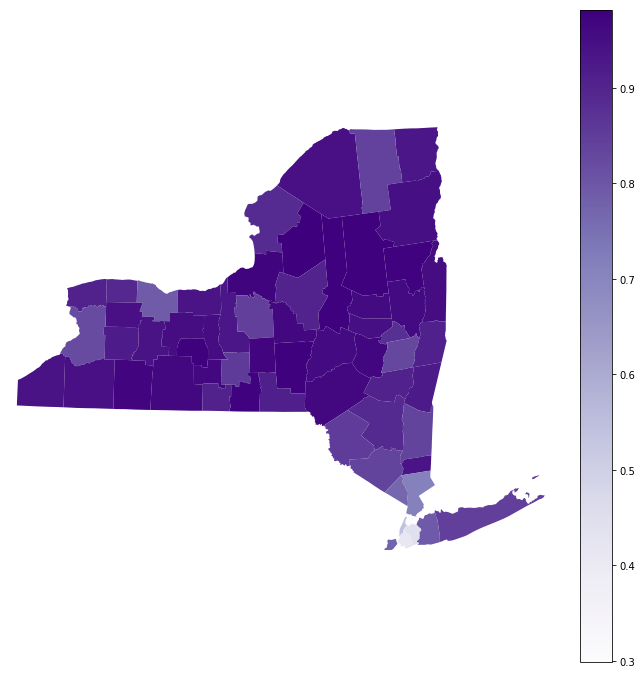

In [9]:
census_tracts = gpd.read_file(geoplot_data.ny_census_partial())
percent_white = census_tracts['WHITE'] / census_tracts['POP2000']

gplt.choropleth(census_tracts, 
                hue=percent_white,  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Purples', 
                linewidth=0.5, 
                k=None,  # Do not bin our counties.
                legend=True,
                figsize=(12, 12))

Note how we used ``k=None`` in this example, to show just how anomalous New York City is!

You can display the same data by oftesetting the size of the geometry with how strong the effect is. This is a ``cartogram``:

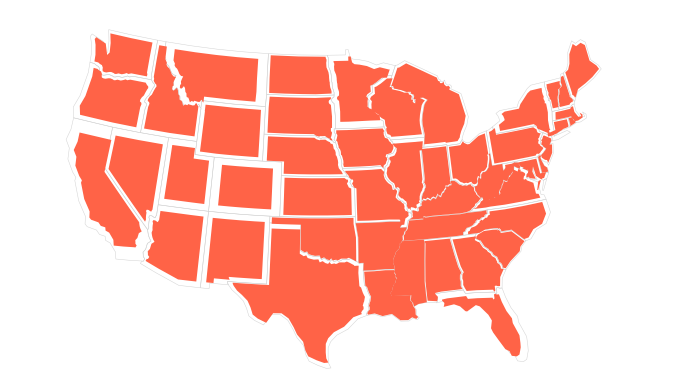

In [10]:
gplt.cartogram(contiguous_usa, scale='Obesity Rate',
               projection=gcrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
               limits=(0.75, 1),
               linewidth=0.5, 
               facecolor='Tomato',
               trace_kwargs={'linewidth': 0.5},
               figsize=(12, 12))

Occassionally you may want to describe a network: traffic movements between cities, for example, of the flow of immigrantion between different countries. For this you can use the ``sankey`` plot. The following plot demos what this looks like for flights out of Los Angeles:

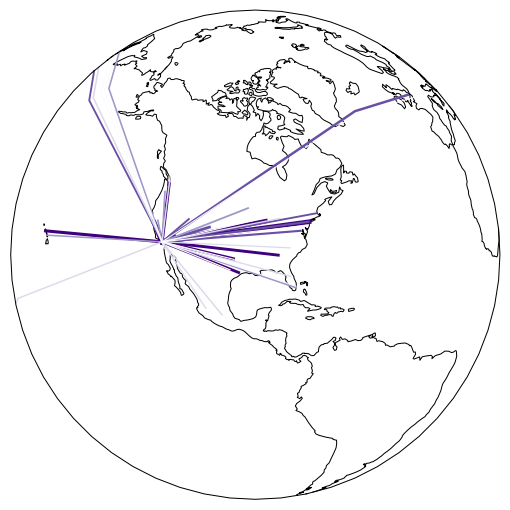

In [11]:
gplt.sankey(la_flights, start='start', end='end', 
            projection=gcrs.Orthographic(), 
            scale='Passengers', hue='Passengers', 
            cmap='Purples', figsize=(9, 9))
ax = plt.gca()
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

This plot also happens to demonstrate that your projection need not be two-dimensional, as ``geoplot`` also provides two different globe projections.

There are other mapping options in ``geoplot``, and many more cool features to explore. But these are the most important ones, and enough to get you started.

## More on geospatial data

So far in all of these examples the data has "just appeared" in the right format. Let's now put paid to what "right format" means. Recall our ``GeoDataFrame`` example from the start:

In [12]:
continental_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
3,177,105549.0,902.0,ND,POINT (-96.78980339999998 46.87718630000012)
30,373,210565.0,505.0,NY,POINT (-77.61555679999998 43.15478450000012)
34,378,145170.0,397.0,NY,POINT (-76.14742439999998 43.04812210000017)
39,386,261310.0,600.0,NY,POINT (-78.87836889999994 42.8864468000001)
61,426,106519.0,118.0,MA,POINT (-71.31617179999989 42.63342470000003)


A ``GeoDataFrame`` contains ``shapely`` geometries in the ``geometry`` column. In this case, we can inspect an entry to see that we have a ``Point`` element:

In [13]:
type(continental_cities.geometry.iloc[0])

shapely.geometry.point.Point

[``shapely``](https://toblerity.org/shapely/manual.html) is the underlying geospatial data definitions and operations library. A valid ``GeoDataFrame`` provides a valid ``shapely.geometry`` object (or a ``NaN``) for every record in the dataset.

So how do you get data in this format?

There are a number of data formats specific to geospatial data&mdash;things like ``SHP``, ``GeoJSON``, and ``KML``&mdash;which ``geopandas`` can read in directly. In this case you can read the data into memory with something like so:

In [14]:
path_to_file = geoplot_data.contiguous_usa()
gpd.read_file(path_to_file).head()

,id,adm1_code,State,geometry
0,0,USA-3514,Minnesota,"POLYGON ((-89.59940899999999 48.010274, -89.48..."
1,1,USA-3515,Montana,"POLYGON ((-111.194189 44.561156, -111.291548 4..."
2,2,USA-3516,North Dakota,"POLYGON ((-96.601359 46.351357, -96.5389080000..."
3,4,USA-3518,Idaho,"POLYGON ((-111.049728 44.488163, -111.050245 4..."
4,5,USA-3519,Washington,"POLYGON ((-116.998073 46.33017, -116.906528 46..."


You can proceed to plotting things from there.

Alternatively, you may need or want to generate the geometry yourself. The majority of datasets are served in non-geospatial formats, like ``CSV`` and ``XLS`` files. But these datasets often *contain* geospatial information: latitude and longitude, for example (point data); or references to the counties or states or neighborhoods that the record occurs in (polygonal data).

In these cases, you'll need to do some processing work to unlock your data's geospatial context. For example, suppose we've the following data:

In [15]:
collisions = gpd.read_file(geoplot_data.nyc_collision_factors())
cols = ['LATITUDE', 'LONGITUDE', 'DATE', 'TIME']
collisions = pd.DataFrame(collisions.loc[:, cols].values, columns=cols)
collisions.head()

,LATITUDE,LONGITUDE,DATE,TIME
0,40.6625,-73.872,11/10/2016,16:11:00
1,40.7213,-74.0083,11/10/2016,05:11:00
2,40.688,-73.9976,04/16/2016,09:15:00
3,40.7192,-73.8545,04/15/2016,10:20:00
4,40.6321,-73.9527,04/15/2016,10:35:00


This is an example of a ``pandas`` ``DataFrame``:

In [16]:
type(collisions)

pandas.core.frame.DataFrame

To convert this to a ``GeoDataFrame``, we isolate the geometry...

In [17]:
from shapely.geometry import Point

geometry = collisions.apply(
    lambda collision: Point(float(collision['LONGITUDE']), float(collision['LATITUDE'])), 
    axis='columns'
)
geometry.head()

0    POINT (-73.87200679999999 40.66251389999999)
1                  POINT (-74.0083444 40.7213228)
2                  POINT (-73.9975625 40.6879989)
3                  POINT (-73.8545422 40.7192276)
4                  POINT (-73.9527315 40.6321467)
dtype: object

...and assign that to the ``GeoDataFrame``. Once that's done, we have what we want:

In [18]:
collision_points = gpd.GeoDataFrame(collisions, geometry=geometry)
collision_points.head()

,LATITUDE,LONGITUDE,DATE,TIME,geometry
0,40.6625,-73.872,11/10/2016,16:11:00,POINT (-73.87200679999999 40.66251389999999)
1,40.7213,-74.0083,11/10/2016,05:11:00,POINT (-74.0083444 40.7213228)
2,40.688,-73.9976,04/16/2016,09:15:00,POINT (-73.9975625 40.6879989)
3,40.7192,-73.8545,04/15/2016,10:20:00,POINT (-73.8545422 40.7192276)
4,40.6321,-73.9527,04/15/2016,10:35:00,POINT (-73.9527315 40.6321467)


In [19]:
type(collision_points)

geopandas.geodataframe.GeoDataFrame

Not all such processing jobs will be this easy. But it should usually be relatively simple to do and gives you access to a whole other ecosystem of useful tools!

<!--
In these cases, you can read the data into a ``pandas`` ``DataFrame`` using that library's file-reading features. Then you need to stitch the geospatial context back together. If your dataset contains latitudes and longitudes, you can use ``shapely`` to create new ``Point`` objects for your records. If your dataset contains named references to regions of some kind, you will need to work a little harder: you need to aggregate your dataset into regions, and join your dataset against a geospatial dataset containing regional definitions.
-->

## Further reading

The [Gallery](../Gallery.html) contains many more awesome ``geoplot`` demos. And to learn more about specific plot types, see the [API Reference](../api.html).

To learn more about working with geospatial data in Python refer to [this complimentary tutorial](https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorial/Data.ipynb). Similarly, to learn more about projections, [click here](https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorial/Projections.ipynb).

Once you're ready to use ``geoplot`` in your own projects, refer to [Installation](../Installation.html). 